Intel image Classification 6 sınıflı veri setinde Buildings, Forest, Glacier, Mountain, Sea, Street'larını tahmin etmeyi amaçlayan CNN modeli üzerinden çalıştım. 
Bu projeyi oluşturmadan önce 3 tane modelle daha çalıştım. İlkinde Düşük doğruluk alırken (%60) ikincisinden %86 gibi yüksek doğruluklara ulaştım fakat 50 epochlu olan modelde 1.5 saatte sadece 15 epochlara ulaşabildim. Bu modelde 20 dk da %76 gibi accuracy e sahip oldum.

In [2]:
# 0) KÜTÜPHANELER ve AYARLAR
import os, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Tekrarlanabilirlik
seed = 42
tf.random.set_seed(seed); np.random.seed(seed); random.seed(seed)

# Cihaz & sürüm bilgisi
print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.18.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


Önceki modellerimde ilk validatio_split kullanmamıştım ve ayrı bir val. seti ayırmamıştım. Bu da overfit olmasına ve accuracy nın gerçekleri yansıtmamasına sebep oldu.
Şimdi validation_split i 0.15 oranunda tutuyoruz. Ve böylelikle loss kontrolu sayesinde overfit yani ezberleme azaldı. Accuracy %76 lara kadar yükseldi.

In [3]:
# 1) YOLLAR ve PARAMETRELER
train_path = "/kaggle/input/intel-image-classification/seg_train/seg_train"
test_path  = "/kaggle/input/intel-image-classification/seg_test/seg_test"

# HIZ ODAKLI BOYUT ve BATCH — istersen 224/228’e çıkarabilirsin
IMG_SIZE   = (192, 192)   # (224/228) daha yavaş ama biraz daha iyi olabilir
BATCH_SIZE = 64           # OOM olursa 48/32'ye indir

# Mixed Precision (FP16) → hem hız hem VRAM kazancı
mixed_precision.set_global_policy("mixed_float16")

# 2) DATASET OLUŞTURMA (train / val / test)
AUTOTUNE = tf.data.AUTOTUNE
norm = tf.keras.layers.Rescaling(1./255)

# Data augmentation sadece eğitimde
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
], name="data_aug")

# Train'den ayrıca validation split ayıralım (yönerge gereği)
train_raw = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.15,     # %15 validasyon
    subset="training",
    seed=seed
)
val_raw = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.15,
    subset="validation",
    seed=seed
)
test_raw = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,             # rapor ve CM için sıra sabit
    seed=seed
)

class_names = train_raw.class_names
num_classes = len(class_names)
print("Sınıflar:", class_names)

# Pipeline hız opsiyonları
opts = tf.data.Options()
opts.experimental_deterministic = False  # performans için determinism kapalı

# Eğitim: normalize -> cache -> shuffle -> augment (GPU) -> prefetch
train_ds = (train_raw
            .map(lambda x,y: (norm(x), y), num_parallel_calls=AUTOTUNE)
            .cache()
            .shuffle(2000, seed=seed)
            .map(lambda x,y: (data_augmentation(x, training=True), y),
                 num_parallel_calls=AUTOTUNE)
            .with_options(opts)
            .prefetch(AUTOTUNE))

# Validasyon/Test: normalize -> cache -> prefetch (augment yok)
val_ds = (val_raw
          .map(lambda x,y: (norm(x), y), num_parallel_calls=AUTOTUNE)
          .cache()
          .with_options(opts)
          .prefetch(AUTOTUNE))

test_ds = (test_raw
           .map(lambda x,y: (norm(x), y), num_parallel_calls=AUTOTUNE)
           .cache()
           .with_options(opts)
           .prefetch(AUTOTUNE))


I0000 00:00:1758890084.639955      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758890084.640671      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 14034 files belonging to 6 classes.
Using 11929 files for training.
Found 14034 files belonging to 6 classes.
Using 2105 files for validation.
Found 3000 files belonging to 6 classes.
Sınıflar: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Model mimarisinde 5 adet Conv2D bloğu ve 2 dense katmanı var. her Conv2D katmanında L2 Regularizer kullanarak overfittingi öneledim. Dropout oranını da 0.2 seçtim. 

Eski modellerimde regularizer yoktu, ve dropout tek yerdeydi weight büyüdü model ezberledi (overfit)Accuracy %63 civarı. Şimdi ise kernel_regularizer=l2(1e-4) ve dengeli dropout (0.20) ekledik artık daha stabil ve Accuracy %76.

In [4]:
# 3) CNN MODELİ (senin mimarine sadık, L2 + Dropout ile regularize)
def build_fast_cnn(input_shape=IMG_SIZE+(3,), dropout=0.20, wd=1e-4):
    m = Sequential([
        Input(shape=input_shape),
        Conv2D(32,(5,5),activation='relu', kernel_regularizer=l2(wd)),
        MaxPooling2D(2,2),

        Conv2D(32,(5,5),activation='relu', kernel_regularizer=l2(wd)),
        MaxPooling2D(2,2),

        Conv2D(64,(3,3),activation='relu', kernel_regularizer=l2(wd)),
        MaxPooling2D(2,2),

        Conv2D(128,(3,3),activation='relu', kernel_regularizer=l2(wd)),
        MaxPooling2D(2,2),

        Conv2D(256,(3,3),activation='relu', kernel_regularizer=l2(wd)),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(dropout),
        Dense(128, activation='relu'),
        Dropout(dropout),

        # Mixed precision kullanırken çıkış katmanını float32 yapmak önemli
        Dense(num_classes, activation='softmax', dtype='float32'),
    ])
    return m

model = build_fast_cnn()
op = Adamax(learning_rate=5e-4)
model.compile(optimizer=op,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              steps_per_execution=64)  # Python overhead’i azaltır
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 188, 188, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 94, 94, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 43, 43, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,662,182 (6.34 MB)

 Trainable params: 1,662,182 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

Eski modelimde IMG_SIZE = 228, BATCH_SIZE=32 iken 15 epoch - 90 dk sürdü ama yüksek doğruluk oranına sahipti (%86).
Şimdi IMG_SIZE=192, BATCH_SIZE=64 ile eğitim süresi 20 dk ama doğrıluk oranı düştü. (%76)

EarlyStopping: Val accuracy 4 epoch boyunca artmazsa eğitim duruyor.
ReduceLROnPlateau: Val loss iyileşmezse öğrenme hızı %30 azaltılıyor.

In [5]:
# 4) EĞİTİM (EarlyStopping + LR Plateau)
early   = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2,
                            min_lr=1e-6, verbose=1)

EPOCHS = 30  # genelde 10–20’de durur
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early, plateau],
    verbose=1
)

Epoch 1/30


I0000 00:00:1758890153.141539     110 service.cc:148] XLA service 0x7da188007720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758890153.143034     110 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758890153.143251     110 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758890153.890301     110 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-09-26 12:36:01.877462: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{k2=2} for conv (f16[32,5,5,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,94,94,32]{3,2,1,0}, f16[64,90,90,32]{3,2,1,0}), window={size=5x5}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0"

187/187 ━━━━━━━━━━━━━━━━━━━━ 132s 219ms/step - accuracy: 0.4000 - loss: 1.4416 - val_accuracy: 0.5439 - val_loss: 1.1089 - learning_rate: 5.0000e-04
Epoch 2/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 176ms/step - accuracy: 0.5378 - loss: 1.1590 - val_accuracy: 0.6185 - val_loss: 0.9854 - learning_rate: 5.0000e-04
Epoch 3/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 177ms/step - accuracy: 0.6057 - loss: 1.0341 - val_accuracy: 0.6290 - val_loss: 0.9562 - learning_rate: 5.0000e-04
Epoch 4/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 178ms/step - accuracy: 0.6366 - loss: 0.9706 - val_accuracy: 0.6774 - val_loss: 0.8449 - learning_rate: 5.0000e-04
Epoch 5/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 175ms/step - accuracy: 0.6646 - loss: 0.9201 - val_accuracy: 0.6789 - val_loss: 0.8491 - learning_rate: 5.0000e-04
Epoch 6/30
129/187 ━━━━━━━━━━━━━━━━━━━━ 14s 255ms/step - accuracy: 0.6845 - loss: 0.8820
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 177ms/step - accu

Eğitim ve doğrulama loss/Accuracy ile grafikleri çiziyor. Bunun sayade 
-aşırı öğrenme var mı
- Model hangi epoch'ta durmalı?
  gibi soruları yanıtlayabiliyoruz.

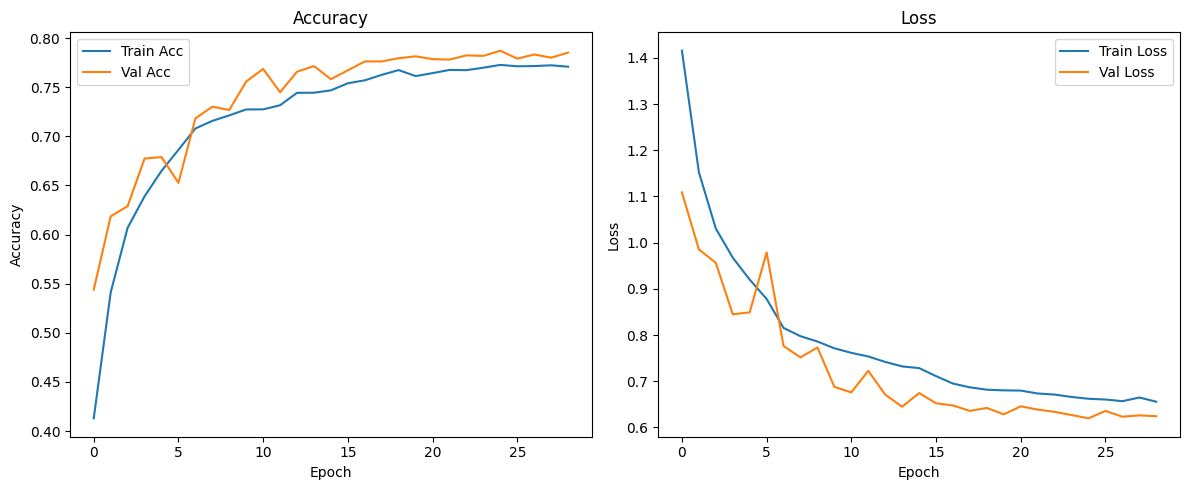

In [6]:
# 5) ÖĞRENME EĞRİLERİ (Accuracy & Loss)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy')
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss')
plt.tight_layout(); plt.show()

Aşağıda test seti üzerinden model performansını ölçüyoruz.
Ve ayrıca confusion matrix ile hangi sınıfların hangı sınıflarla daha çok karıştığını da anlayabiliyoruz.

In [7]:
# 6) TEST DEĞERLENDİRME
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test Accuracy: {test_acc*100:.2f}%  |  Test Loss: {test_loss:.4f}")

Test Accuracy: 78.60%  |  Test Loss: 0.6360


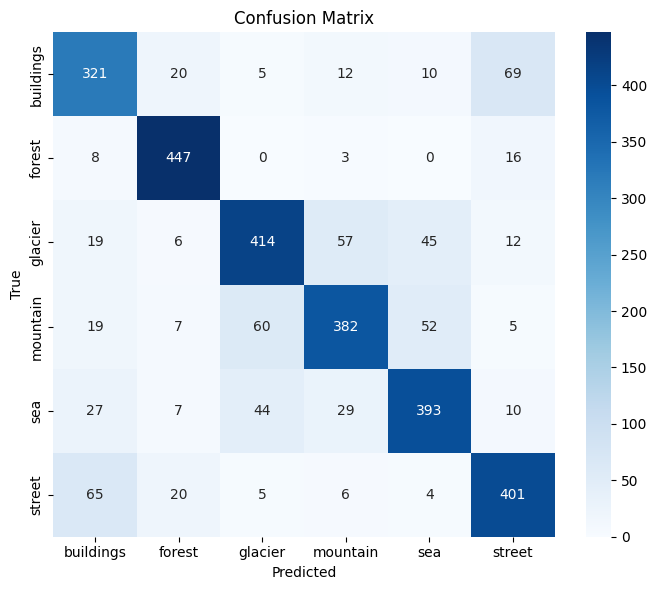

              precision    recall  f1-score   support

   buildings       0.70      0.73      0.72       437
      forest       0.88      0.94      0.91       474
     glacier       0.78      0.75      0.77       553
    mountain       0.78      0.73      0.75       525
         sea       0.78      0.77      0.78       510
      street       0.78      0.80      0.79       501

    accuracy                           0.79      3000
   macro avg       0.78      0.79      0.79      3000
weighted avg       0.79      0.79      0.79      3000



In [8]:
# 7) CONFUSION MATRIX & CLASSIFICATION REPORT
y_true, y_pred = [], []
for images, labels in test_ds:
    probs = model.predict(images, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.tight_layout(); plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

model.input yüzünden “layer … never been called” hatası alıyordum.
Katmanlara tek tek wrapper (build_gradcam_wrapper) yazılınca modelin hangi bölgelere baktığı daha netleşti.

Last conv layer: conv2d_4


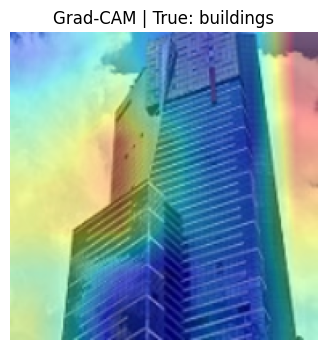

In [9]:
# --- Grad-CAM: model.input kullanmadan, katmanları tek tek ilerleterek (stabil) ---
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D

# 1) Son Conv2D katmanını bul
last_conv = [l for l in model.layers if isinstance(l, Conv2D)][-1]
print("Last conv layer:", last_conv.name)

# 2) Katmanları tek tek uygulayarak ara (conv) ve nihai çıktıyı veren bir model kur
def build_gradcam_wrapper(model, last_conv):
    inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.float32)
    x = inputs
    conv_out = None
    for layer in model.layers:
        x = layer(x)
        if layer is last_conv:
            conv_out = x
    outputs = x
    return tf.keras.Model(inputs, [conv_out, outputs])

grad_model = build_gradcam_wrapper(model, last_conv)

def make_gradcam_heatmap(img_1xHxWx3_float32):
    # img_1xHxWx3_float32: (1,H,W,3) ve float32 olmalı
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_1xHxWx3_float32, training=False)
        class_idx = tf.argmax(preds[0])
        target = preds[:, class_idx]

    grads = tape.gradient(target, conv_outputs)              # (1,h,w,c)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))             # (c,)
    conv_map = conv_outputs[0]                               # (h,w,c)
    heatmap = conv_map @ pooled[..., tf.newaxis]             # (h,w,1)
    heatmap = tf.squeeze(heatmap)                            # (h,w)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)

    # 🔧 Heatmap'i input resim boyutuna büyüt ve float32 yap
    heatmap = tf.image.resize(heatmap[..., tf.newaxis], IMG_SIZE)  # (H,W,1)
    heatmap = tf.squeeze(heatmap).numpy().astype(np.float32)       # (H,W) float32
    return heatmap

# 3) Görselleştir (dtype düzeltmeleriyle)
for images, labels in test_ds.take(1):
    # Mixed-precision yüzünden images genelde float16 olur -> float32'ye çevir
    base = tf.cast(images[0], tf.float32).numpy()                  # (H,W,3) float32, 0..1
    img  = base[None, ...]                                         # (1,H,W,3)

    heatmap = make_gradcam_heatmap(img)

    plt.figure(figsize=(5,4))
    plt.imshow(base.astype(np.float32))                            # Matplotlib float32 sever
    plt.imshow(heatmap, cmap='jet', alpha=0.4)                     # heatmap de float32
    plt.axis("off")
    plt.title(f"Grad-CAM | True: {class_names[int(labels[0].numpy())]}")
    plt.show()
    break


Aşağıda 25 rastgele test görselinin "Gerçek vs Tahmin" başlıklarıyla gösterildi ve böylelikle
yanlış sınıflandırmaları görsel olarak inceleyebiliyoruz.

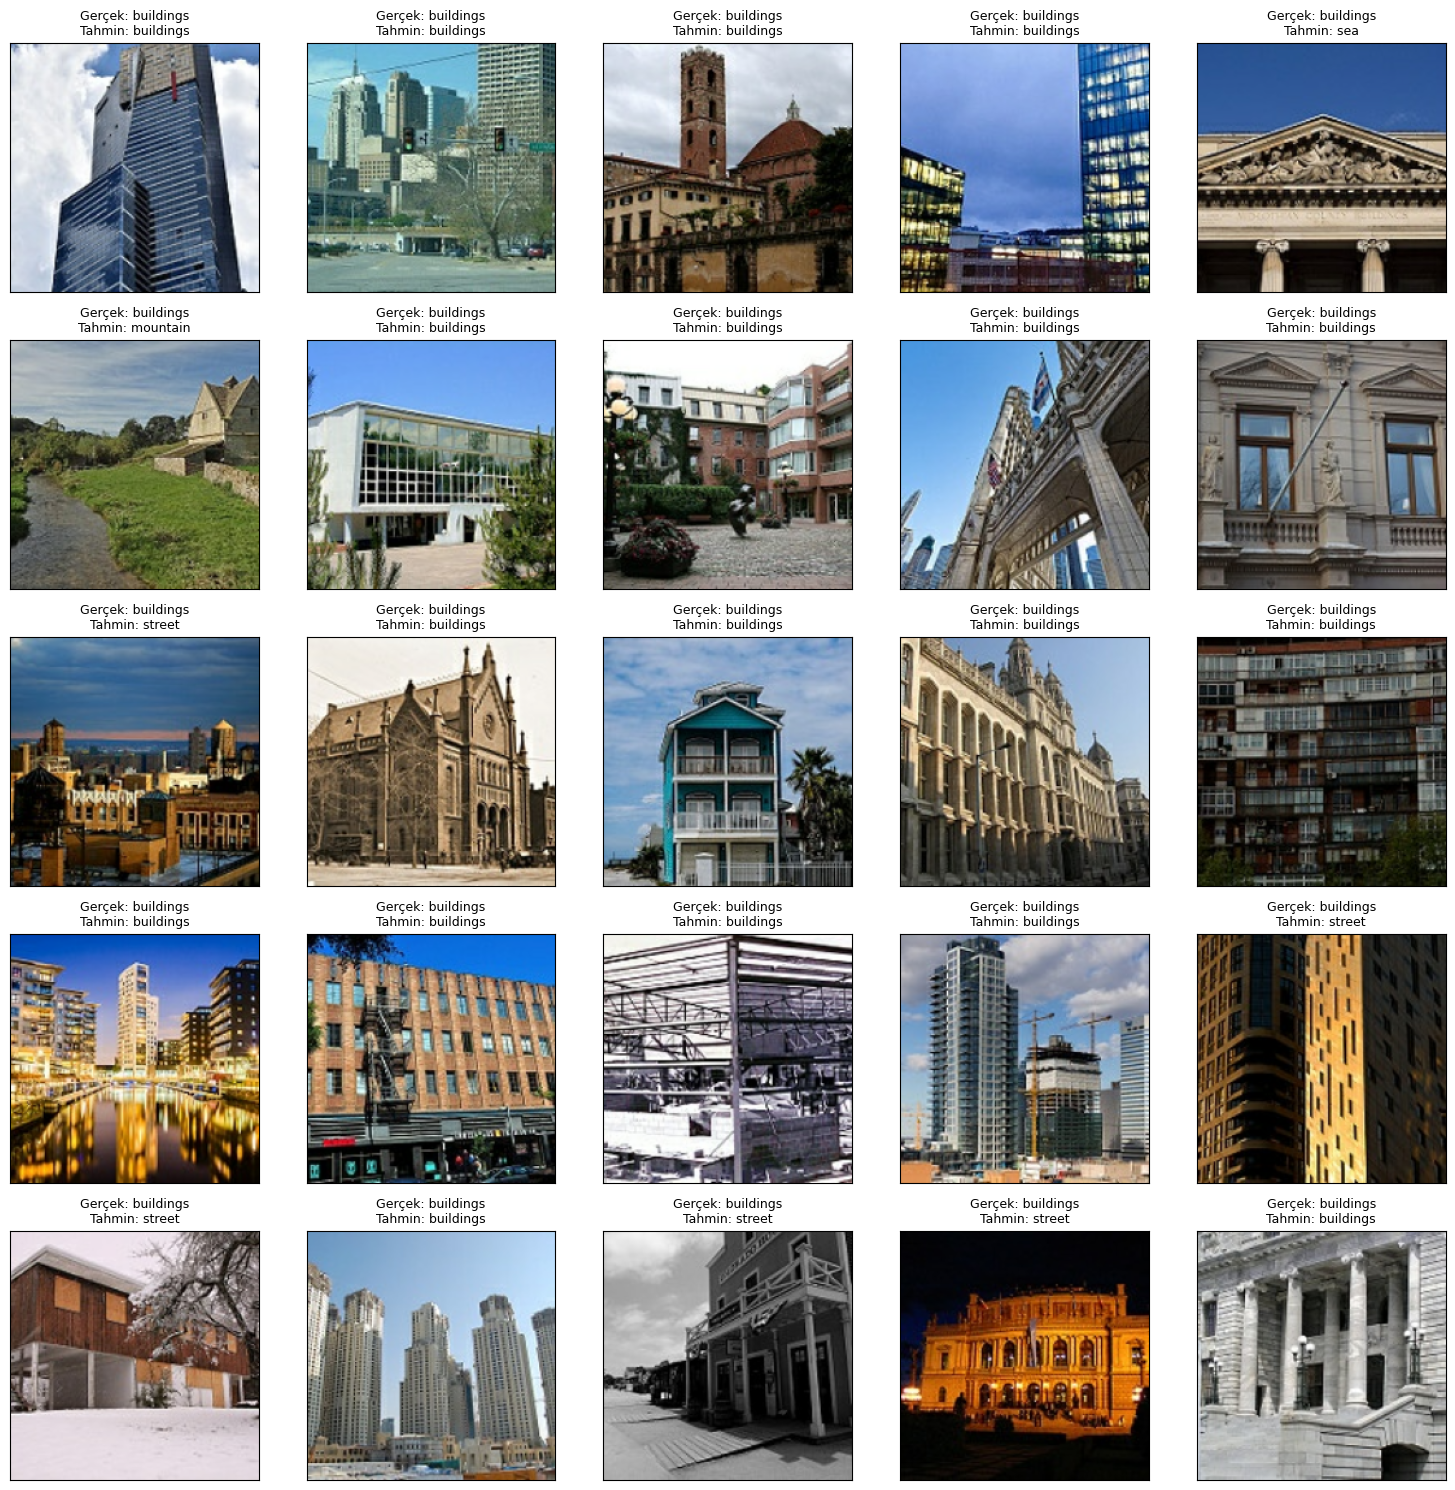

In [10]:
# --- 25 örnek: Gerçek ve Tahmin Grid ---
def show_predictions_grid_simple(model, dataset, class_names, n=25, cols=5):
    imgs, trues, preds = [], [], []
    got = 0
    for batch_imgs, batch_labels in dataset:
        batch_imgs32 = tf.cast(batch_imgs, tf.float32)
        p = model.predict(batch_imgs32, verbose=0)
        yhat = np.argmax(p, axis=1)

        for i in range(len(batch_labels)):
            imgs.append(batch_imgs32[i].numpy())
            trues.append(int(batch_labels[i].numpy()))
            preds.append(int(yhat[i]))
            got += 1
            if got >= n:
                break
        if got >= n:
            break

    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(cols*3.0, rows*3.0))
    for i in range(n):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(imgs[i])
        true_label = class_names[trues[i]]
        pred_label = class_names[preds[i]]
        ax.set_title(f"Gerçek: {true_label}\nTahmin: {pred_label}", fontsize=9)
        ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout(); plt.show()

# Kullanım:
show_predictions_grid_simple(model, test_ds, class_names, n=25, cols=5)


Farklı Öğrenme oranlarını deneyip en iyi valid accuracy i deneyip, modelin hangi LR ile daha iyi genelleme yaptığını bulmamıza yarıyor.

In [11]:
# 9) BONUS! BASİT HİPERPARAMETRE DENEYİ 
def try_learning_rates(lrs=[1e-3, 5e-4, 1e-4], epochs=4):
    results = []
    for lr in lrs:
        m = build_fast_cnn()
        m.compile(optimizer=Adamax(learning_rate=lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'],
                  steps_per_execution=64)
        h = m.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=0)
        best_val = max(h.history['val_accuracy'])
        results.append((lr, best_val))
        print(f"LR={lr:.0e} -> Best Val Acc: {best_val:.4f}")
    return results
try_learning_rates()

LR=1e-03 -> Best Val Acc: 0.6808
LR=5e-04 -> Best Val Acc: 0.6993
LR=1e-04 -> Best Val Acc: 0.5824


[(0.001, 0.6807600855827332),
 (0.0005, 0.6992874145507812),
 (0.0001, 0.5824227929115295)]